# Blackbird Motor Estimations

This notebook is for looking at the forces and moments generated by the motors and see how well they matched up with the expected theoretical model presented.

## Loading the Dataset

First thing to do is to load in the dataset and apply corrections and methods examined from the Force Estimation and Rotation Angles notebooks.

In [1]:
import importlib
import os
import sys
import time
sys.path.append(os.path.abspath('../functions'))

import read_blackbird_dataset as rbd
import dsp
import quaternions

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
t1 = time.time()
test_df = rbd.read_blackbird_test('figure8', 'Constant', 0.5)
print("Time elapsed: %f" % (time.time() - t1))

Time elapsed: 36.420446


In [3]:
importlib.reload(rbd)
t1 = time.time()
test_df = rbd.imu_installation_correction(test_df)
t2 = time.time()
test_df = rbd.inertial_position_derivatives_estimation(test_df)
t3 = time.time()
test_df = rbd.consistent_quaternions(test_df)
t4 = time.time()
test_df = rbd.inertial_quaternion_derivatives_estimation(test_df)
t5 = time.time()
test_df = rbd.body_angular_derivative_estimate(test_df)
t6 = time.time()

print('Time elapsed breakdown')
print('\tIMU correction = %f [s]' % (t2 - t1))
print('\tInertial position derivative estimates = %f [s]' % (t3 - t2))
print('\tConsistent quaternions = %f [s]' % (t4 - t3))
print('\tQuaternion derivate estimates = %f [s]' % (t5 - t4))
print('\tBody rates from quaternion derivatives = %f [s]' % (t6-t5))
print('Total time elapsed = %f' % (t6 - t1))

test_df.info()

Time elapsed breakdown
	IMU correction = 0.278837 [s]
	Inertial position derivative estimates = 119.338586 [s]
	Consistent quaternions = 2.481979 [s]
	Quaternion derivate estimates = 165.186210 [s]
	Body rates from quaternion derivatives = 3.914860 [s]
Total time elapsed = 291.200473
<class 'pandas.core.frame.DataFrame'>
Int64Index: 795505 entries, 1526617312016142000 to 1526617526742182000
Data columns (total 64 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   PWM1                            39823 non-null  float64
 1   PWM2                            39823 non-null  float64
 2   PWM3                            39823 non-null  float64
 3   PWM4                            39823 non-null  float64
 4   angular_velocity_covariance     21298 non-null  object 
 5   ax_I_[m/s2]                     77287 non-null  float64
 6   ax_[m/s2]                       21298 non-null  float64
 7   ay_I_[m/s2]        

In [4]:
# Getting rid of excess indices
test_df = test_df.groupby(level=0).sum().replace(0., np.nan)

## Transform Inertial Frame Derivatives to Body Frame

Since the motors are rigidly attached to the frame, all translational and rotational accelerations should be in the body frame for all estimations.

In [5]:
# Get Inertial frame measurements
quaternions_inertial_df = test_df[['qw_est',
                                   'qx_est',
                                   'qy_est',
                                   'qz_est',
                                   'px_[m]_est',
                                   'py_[m]_est',
                                   'pz_[m]_est',
                                   'vx_I_[m/s]',
                                   'vy_I_[m/s]',
                                   'vz_I_[m/s]',
                                   'ax_I_[m/s2]',
                                   'ay_I_[m/s2]',
                                   'az_I_[m/s2]']].dropna()

# Get Body frame measurements
quaternions_body_df = test_df[['omegax_qest',
                               'omegay_qest',
                               'omegaz_qest',
                               'omegadotx_qest',
                               'omegadoty_qest',
                               'omegadotz_qest']].dropna()

# Get a spare index
q_index = quaternions_body_df.index

# Time vector from index
rbts2s = 10 ** -9
t_q = (q_index - test_df.index[0]) * rbts2s
t_q = t_q.astype('float')

# Reset Index
quaternions_inertial_df = quaternions_inertial_df.reset_index()
quaternions_body_df = quaternions_body_df.reset_index()

In [29]:
def cross_product_skew_symmetric_matrix(x, y, z):
    CROSS = np.array([[0, -y, z],
                      [y, 0, -x],
                      [-z, x, 0]])
    return CROSS

# Constants
vehicle = rbd.BlackbirdVehicle()
g = 9.81 # [m/s2]
Inertia = vehicle.get_inertia_matrix()
Iinv = np.linalg.inv(Inertia)

# Preallocate body value matrices matrix
V_B = np.zeros((len(quaternions_body_df.index), 3)) # Vehicle velocity in body frame
a_B = np.zeros((len(quaternions_body_df.index), 3)) # Used against IMU to benchmark quaternion based accuracy
omegadot_B = np.zeros((len(quaternions_body_df.index), 3))

# Inertial frame acceleration in body frame. All body effects sum to this
a_I_B = np.zeros((len(quaternions_body_df.index), 3))
a_transport_B = np.zeros((len(quaternions_body_df.index), 3)) # omega cross v from transport equation
a_gravity_B = np.zeros((len(quaternions_body_df.index), 3)) # Gravity in body frame

# Inertial frame rotational derivative in body. All body effects sum to this
omegadot_I_B = np.zeros((len(quaternions_body_df.index), 3))
# omega cross (I times omega) from transport equation
omegadot_transport_B = np.zeros((len(quaternions_body_df.index), 3)) 

# Transform Inertial frame into Body Frame
for i in range(len(quaternions_inertial_df.index)):
    # Get Rotation matrix from quaternions
    qw = quaternions_inertial_df.loc[i, 'qw_est']
    qx = quaternions_inertial_df.loc[i, 'qx_est']
    qy = quaternions_inertial_df.loc[i, 'qy_est']
    qz = quaternions_inertial_df.loc[i, 'qz_est']
    R = quaternions.Rmatrix_from_quaternions(qw, qx, qy, qz)

    # Get inertial frame velocity and acceleration
    vx = quaternions_inertial_df.loc[i, 'vx_I_[m/s]']
    vy = quaternions_inertial_df.loc[i, 'vy_I_[m/s]']
    vz = quaternions_inertial_df.loc[i, 'vz_I_[m/s]']
    ax = quaternions_inertial_df.loc[i, 'ax_I_[m/s2]']
    ay = quaternions_inertial_df.loc[i, 'ay_I_[m/s2]']
    az = quaternions_inertial_df.loc[i, 'az_I_[m/s2]']

    # Get rotation rates and accelerations from body frame
    omegax = quaternions_body_df.loc[i, 'omegax_qest']
    omegay = quaternions_body_df.loc[i, 'omegay_qest']
    omegaz = quaternions_body_df.loc[i, 'omegaz_qest']
    omegadotx = quaternions_body_df.loc[i, 'omegadotx_qest']
    omegadoty = quaternions_body_df.loc[i, 'omegadoty_qest']
    omegadotz = quaternions_body_df.loc[i, 'omegadotz_qest']

    # Get cross product equivalent matrix
    OmegaCross = cross_product_skew_symmetric_matrix(omegax, omegay, omegaz)
    
    # Transform velocity from inertial into body
    V_I = np.array([vx, vy, vz]).T
    V_B[i] = np.matmul(R, V_I).T
    
    # Transform translational acceleration (a_B = a_I|B - omega cross v_B)
    a_I = np.array([ax, ay, az]).T
    a_I_B[i] = np.matmul(R, a_I).T
    a_transport_B[i] = np.matmul(OmegaCross, V_B[i]).T
    a_B[i] = a_I_B[i] - a_transport_B[i]
    a_gravity_B[i] = np.matmul(R, np.array([0, 0, g]).T)
    
    # Transform rotational acceleration (alpha_B = alpha_I|B - Iinv (omega cross (I omega)))
    omega = np.array([omegax, omegay, omegaz]).T
    omegadot_I_B[i] = np.array([omegadotx, omegadoty, omegadotz]).T
    omegadot_transport_B[i] = np.matmul(Iinv, np.matmul(OmegaCross, np.matmul(Inertia, omega)))

quaternions_body_df['vx_B_[m/s]'] = V_B[:, 0]
quaternions_body_df['vy_B_[m/s]'] = V_B[:, 1]
quaternions_body_df['vz_B_[m/s]'] = V_B[:, 2]
quaternions_body_df['ax_B_[m/s2]'] = a_B[:, 0]
quaternions_body_df['ay_B_[m/s2]'] = a_B[:, 1]
quaternions_body_df['az_B_[m/s2]'] = a_B[:, 2]
quaternions_body_df['ax_g|B_[m/s2]'] = a_gravity_B[:,0]
quaternions_body_df['ay_g|B_[m/s2]'] = a_gravity_B[:,1]
quaternions_body_df['az_g|B_[m/s2]'] = a_gravity_B[:,2]
quaternions_body_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77287 entries, 0 to 77286
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rosbagTimestamp  77287 non-null  int64  
 1   omegax_qest      77287 non-null  float64
 2   omegay_qest      77287 non-null  float64
 3   omegaz_qest      77287 non-null  float64
 4   omegadotx_qest   77287 non-null  float64
 5   omegadoty_qest   77287 non-null  float64
 6   omegadotz_qest   77287 non-null  float64
 7   vx_B_[m/s]       77287 non-null  float64
 8   vy_B_[m/s]       77287 non-null  float64
 9   vz_B_[m/s]       77287 non-null  float64
 10  ax_B_[m/s2]      77287 non-null  float64
 11  ay_B_[m/s2]      77287 non-null  float64
 12  az_B_[m/s2]      77287 non-null  float64
 13  ax_g|B_[m/s2]    77287 non-null  float64
 14  ay_g|B_[m/s2]    77287 non-null  float64
 15  az_g|B_[m/s2]    77287 non-null  float64
dtypes: float64(15), int64(1)
memory usage: 9.4 MB


In [8]:
a_imu = test_df[['ax_[m/s2]', 'ay_[m/s2]', 'az_[m/s2]']].dropna()
t_imu = (a_imu.index - test_df.index[0]).values * rbts2s
t_imu = t_imu.astype('float')
a_imu = a_imu.values

print(t_imu)
print(a_imu)

[  1.759351   1.769346   1.779572 ... 214.709508 214.719489 214.729519]
[[ 0.39224178  0.05371109 -9.74158382]
 [ 0.39395699  0.05321441 -9.76864719]
 [ 0.40324804  0.05694842 -9.74429131]
 ...
 [ 0.47276697  0.03919758 -9.70391941]
 [ 0.47823358  0.04428208 -9.69078064]
 [ 0.46408102  0.0645295  -9.68992043]]


<IPython.core.display.Javascript object>


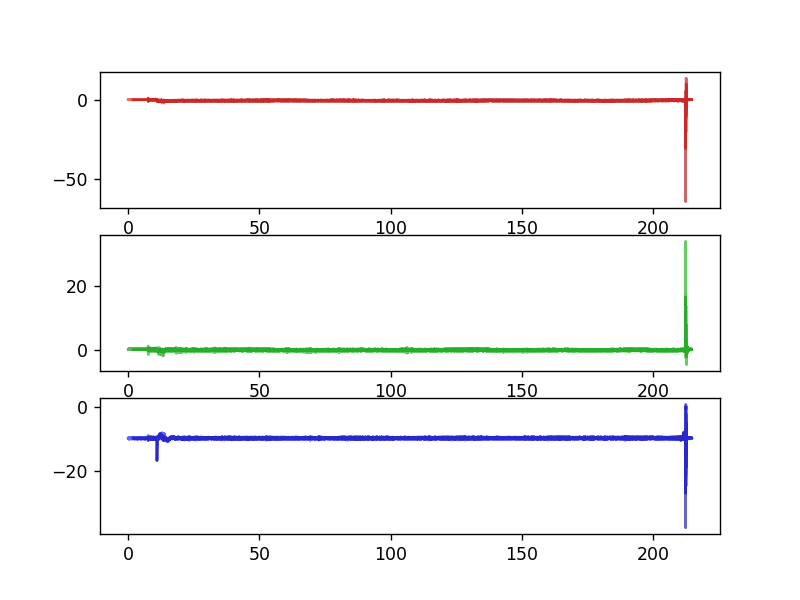

In [9]:
fig, ax = plt.subplots(3,1)

ax[0].plot(t_q, a_B[:,0] - a_gravity_B[:,0], color='r', alpha=0.6)
ax[0].plot(t_imu, a_imu[:,0], color='#aa0000', alpha=0.6)
ax[1].plot(t_q, a_B[:,1] - a_gravity_B[:,1], color='g', alpha=0.6)
ax[1].plot(t_imu, a_imu[:,1], color='#00aa00', alpha=0.6)
ax[2].plot(t_q, a_B[:,2] - a_gravity_B[:,2], color='b', alpha=0.6)
ax[2].plot(t_imu, a_imu[:,2], color='#0000aa', alpha=0.6)

plt.show()

### Determining In-flight versus Grounded

In order to account for the ground providing the counter gravitational force, it is necessary to determine when the vehicle is on the ground. Options evaluated in this order:

1. Z-position based solely on maximum
2. Z-position from start/ends of the time history assuming the quadcopter starts/ends on the ground

<IPython.core.display.Javascript object>


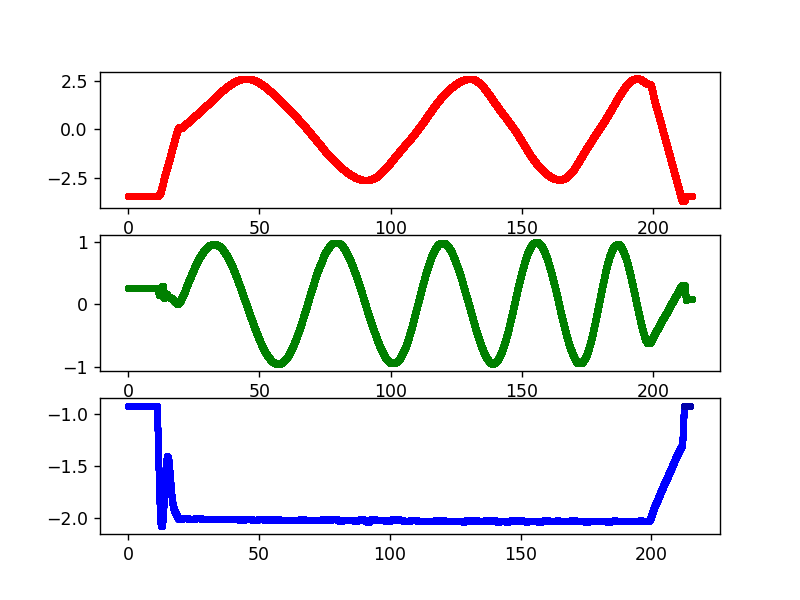

In [10]:
# Find out when its on the ground for zeroing acceleration

z_ground = quaternions_inertial_df['pz_[m]_est'].max()
delta_z = 0.001

p = quaternions_inertial_df[['px_[m]_est', 'py_[m]_est', 'pz_[m]_est']].values
ind_ground = p[:, 2] >= z_ground - delta_z

fig, ax = plt.subplots(3, 1)

ax[0].scatter(t_q, p[:, 0], color='r', marker='.')
ax[1].scatter(t_q, p[:, 1], color='g', marker='.')
ax[2].scatter(t_q, p[:, 2], color='b', marker='.')
ax[2].scatter(t_q[ind_ground], p[ind_ground, 2], color='#0000aa', marker='.')

plt.show()

Looks like there is some variation in floor that prevents the level of accuracy that would be nice ... go figure. Trying option 2.

<IPython.core.display.Javascript object>


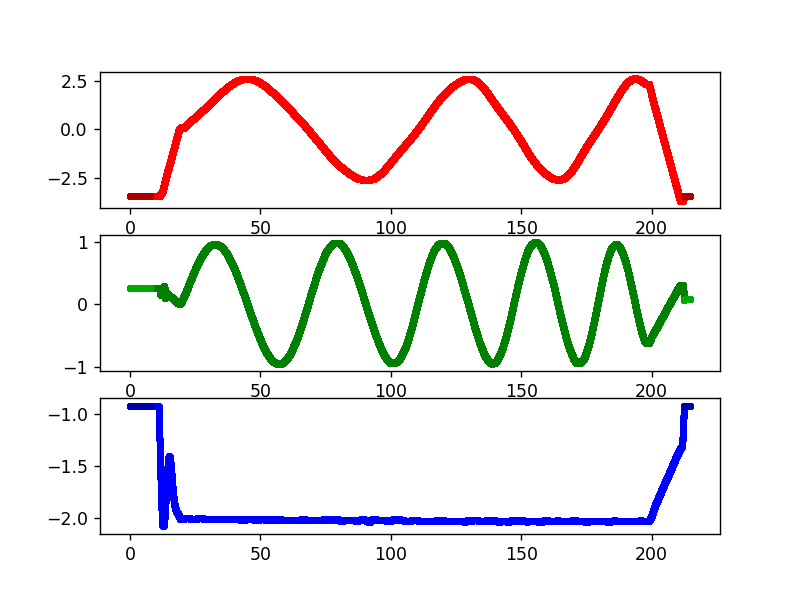

In [11]:
# Find out when its on the ground for zeroing acceleration

delta_z = 0.00025

num_p = p.shape[0]

i_ground_start = (p[:, 2] >= p[0, 2] - delta_z) & (t_q < t_q[int(len(t_q)/2)])
i_ground_stop = (p[:, 2] >= p[-1, 2] - delta_z) & (t_q > t_q[int(len(t_q)/2)])
i_ground = i_ground_start | i_ground_stop

fig, ax = plt.subplots(3, 1)

ax[0].scatter(t_q, p[:, 0], color='r', marker='.')
ax[0].scatter(t_q[i_ground], p[i_ground, 0], color='#aa0000', marker='.')
ax[1].scatter(t_q, p[:, 1], color='g', marker='.')
ax[1].scatter(t_q[i_ground], p[i_ground, 1], color='#00aa00', marker='.')
ax[2].scatter(t_q, p[:, 2], color='b', marker='.')
ax[2].scatter(t_q[i_ground], p[i_ground, 2], color='#0000aa', marker='.')


plt.show()

Option 2 looks to work well, constructing a -g force series from the ground indices to add in acceleration

In [12]:
# creating inertial frame matrix of acceleration due to ground ignoring friction along the surface
a_ground = np.zeros((i_ground.shape[0], 3))
a_ground[i_ground, 2] = -g # upwards acceleration

# Transform Inertial frame into Body Frame
for i in range(a_ground.shape[0]):
    # Get Rotation matrix from quaternions
    qw = quaternions_inertial_df.loc[i, 'qw_est']
    qx = quaternions_inertial_df.loc[i, 'qx_est']
    qy = quaternions_inertial_df.loc[i, 'qy_est']
    qz = quaternions_inertial_df.loc[i, 'qz_est']
    R = quaternions.Rmatrix_from_quaternions(qw, qx, qy, qz)
    a_ground[i] = np.matmul(R, a_ground[i].T).T

<IPython.core.display.Javascript object>


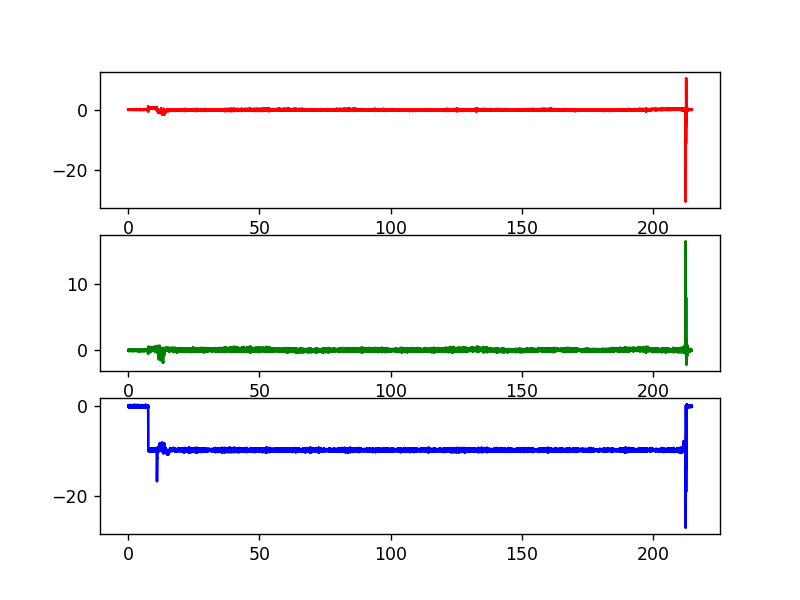

In [13]:
# Unexplained acceleration in the body frame
a_unexplained = a_I_B - (a_transport_B + a_gravity_B + a_ground)

fig, ax = plt.subplots(3, 1)

ax[0].plot(t_q, a_unexplained[:,0], color='r')
ax[1].plot(t_q, a_unexplained[:,1], color='g')
ax[2].plot(t_q, a_unexplained[:,2], color='b')

plt.show()

<IPython.core.display.Javascript object>


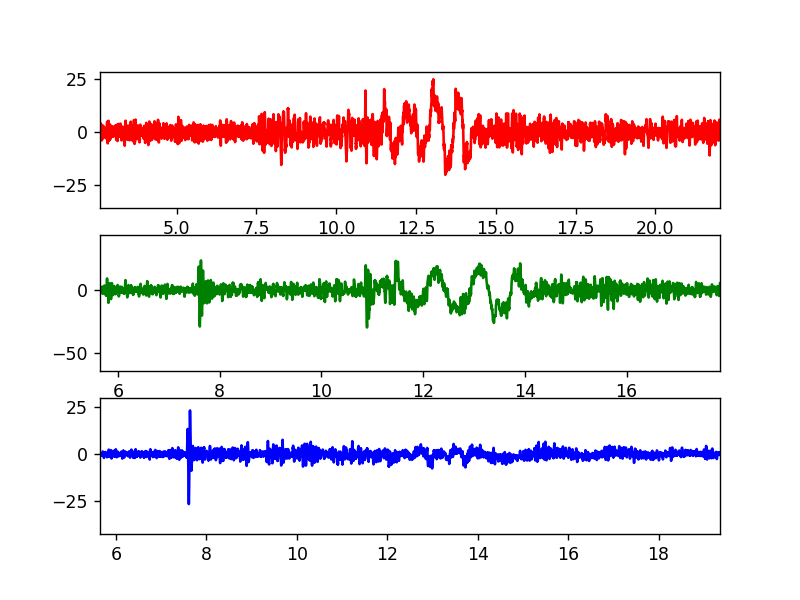

In [30]:
# Unexplained acceleration in the body frame
alpha_unexplained = omegadot_I_B - omegadot_transport_B

fig, ax = plt.subplots(3, 1)

ax[0].plot(t_q, alpha_unexplained[:,0], color='r')
ax[1].plot(t_q, alpha_unexplained[:,1], color='g')
ax[2].plot(t_q, alpha_unexplained[:,2], color='b')

plt.show()

## Examine proposed motor forces

Now that there is a vector of unexplained accelerations, time to import the motor rpms to estimate forces.

In [15]:
motor_rpms = test_df[['rpm1', 'rpm2', 'rpm3', 'rpm4']].dropna()
t_motors = (motor_rpms.index - test_df.index[0]).values * rbts2s
t_motors = t_motors.astype('float')
motor_rpms = motor_rpms.reset_index()

motor_rpms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38272 entries, 0 to 38271
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rosbagTimestamp  38272 non-null  int64  
 1   rpm1             38272 non-null  float64
 2   rpm2             38272 non-null  float64
 3   rpm3             38272 non-null  float64
 4   rpm4             38272 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.5 MB


<IPython.core.display.Javascript object>


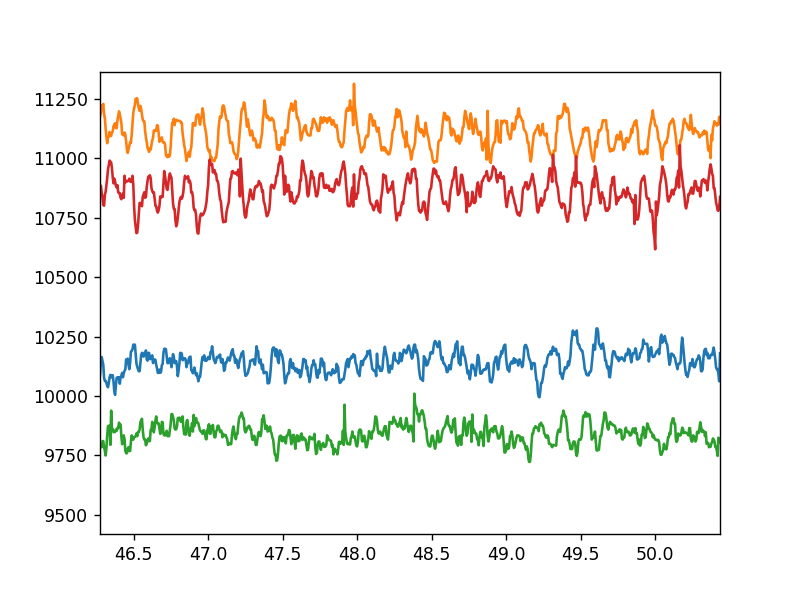

'\ncomment -- the motor rpms look noisy. A SG filter may work an also get omega dot \nwhich may be helpful in estimating time derivatives of inertia matrix\n'

In [16]:
fig, ax = plt.subplots(1,1)

for i in range(4):
    ax.plot(t_motors, motor_rpms['rpm' + str(i+1)], label=('Motor %i' % (i+1)))

plt.show()

"""
comment -- the motor rpms look noisy. A SG filter may work an also get omega dot 
which may be helpful in estimating time derivatives of inertia matrix
"""

In [17]:
# Interpolating from the quaternions
def linear_interpolation(X, Y, x):
    """
    Summary: Linear interpolations on the series given by X, Y for the values in x to return y
    Inputs:
        * X = known input points in strictly increasing order (easy for time series)
        * Y = corresponding output points to X
    Outputs:
        * y = interpolated output values
    Notes:
        * only for 1D case currently
        * I could easily make this a Langrangian interpolation or taylor series from closest point
    """
    # initialize output
    y = np.zeros((x.shape[0], Y.shape[1])) # same number of x entries but same column width as Y
    
    # go through points for interpolation
    NX = X.shape[0]
    for i in range(x.shape[0]):
        xi = x[i]
        ind1 = np.argmin(np.abs(X - xi)) # index of closest element in X to xi
        # The argmin probably slows it down, could use a loop if x is ordered as well
        X1 = X[ind1]
        # Iterate through cases for second index variable
        if xi == X1:
            y[i] = Y[ind1]
            continue
        elif xi < X1:
            if ind1 != 0:
                ind2 = ind1 - 1 # interpolate
            else:
                ind2 = 1  # extrapolate
        else:
            if ind1 != NX - 1:
                ind2 = ind1 + 1  # interpolate
            else:
                ind2 = ind1 - 1 # extrapolate
        X2 = X[ind2]
        
        # Do the interpolation
        Y1 = Y[ind1]
        Y2 = Y[ind2]
        y[i] = Y1 + (xi - X1)*(Y2 - Y1)/(X2 - X1)

    # Return interpolated outputs
    return y

In [18]:
# Interpolate accelerations in quaternion time series to motor time series
a_unexplained_tM = linear_interpolation(t_q, a_unexplained, t_motors)
alpha_unexplained_tM = linear_interpolation(t_q, alpha_unexplained, t_motors)

<IPython.core.display.Javascript object>


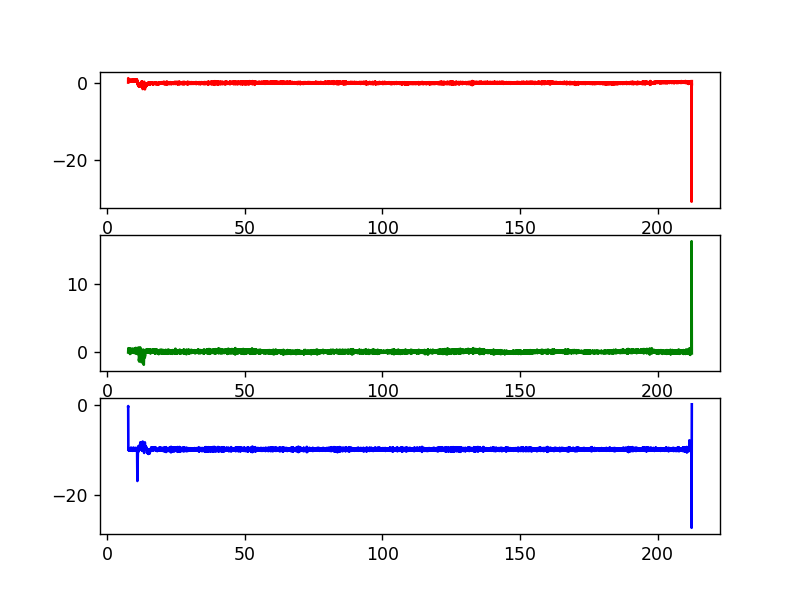

In [19]:
fig, ax = plt.subplots(3,1)

for i, c in zip(list(range(3)), ['r', 'g', 'b']):
    ax[i].plot(t_motors, a_unexplained_tM[:, i], color=c)

plt.show()

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# OLS only on z-body acceleration
X = motor_rpms[['rpm1', 'rpm2', 'rpm3', 'rpm4']].values
y = a_unexplained_tM[:,2] * vehicle.mass
print('Linear Model with intercept')
model = LinearRegression().fit(X, y)
print(model.coef_, model.intercept_)
print(model.score(X, y))

print('\nLinear Model without intercept')
model = LinearRegression(fit_intercept=False).fit(X, y)
print(model.coef_, model.intercept_)
print(model.score(X, y))

# Quadratic model w/ intercept
print('\nQuadratic model with intercept')
X2 = X ** 2
model = LinearRegression().fit(X2, y)
print(model.coef_, model.intercept_)
print(model.score(X2, y))
print(np.mean(model.coef_), vehicle.CT)

# Quadratic model w/o intercept
print('\nQuadratic model without intercept')
model = LinearRegression(fit_intercept=False).fit(X2, y)
print(model.coef_, model.intercept_)
print(model.score(X2, y))
print(np.mean(model.coef_), vehicle.CT)

# Full quadrtic
print('\nFull quadratic model')
poly = PolynomialFeatures(2)
Xpoly = poly.fit_transform(X)
model = LinearRegression(fit_intercept=False).fit(Xpoly, y)
print(model.coef_, model.intercept_)
print(model.score(Xpoly, y))

"""
comment -- the average thrust coefficient is pretty close to their reported value
"""


Linear Model with intercept
[-1.41575866e-05  7.38466011e-06 -1.36828257e-04 -2.03362815e-05] -7.352943635249285
0.03738765959649182

Linear Model without intercept
[-1.34193547e-04  4.88609304e-05 -5.62690893e-04 -2.43839645e-04] 0.0
-0.7062636399395188

Quadratic model with intercept
[-1.77519621e-09 -6.88319563e-11 -6.00484974e-09 -1.13627549e-09] -8.07457948607555
0.034906770880441695
-2.246288346770184e-09 2.27e-08

Quadratic model without intercept
[-1.59734465e-08 -5.14885801e-09 -4.37713199e-08 -2.11937855e-08] 0.0
-2.6328763898016065
-2.1521852479211363e-08 2.27e-08

Full quadratic model
[-9.22906904e+00  3.39124515e-03 -1.72831382e-02 -8.61090563e-03
  2.27562114e-02  4.10136411e-07 -4.85634813e-07 -3.61153801e-07
 -2.73341310e-07 -7.53225474e-09  2.40838729e-06 -1.23680019e-07
 -3.18601872e-08 -1.26915865e-06 -2.93051414e-07] 0.0
0.16880969349957786


'\ncomment -- the average thrust coefficient is pretty close to their reported value\n'

It looks like z accelerations alone won't allow for accurate thrust coefficient estimations. I'll try adding in X and Y body axis moments.

<IPython.core.display.Javascript object>


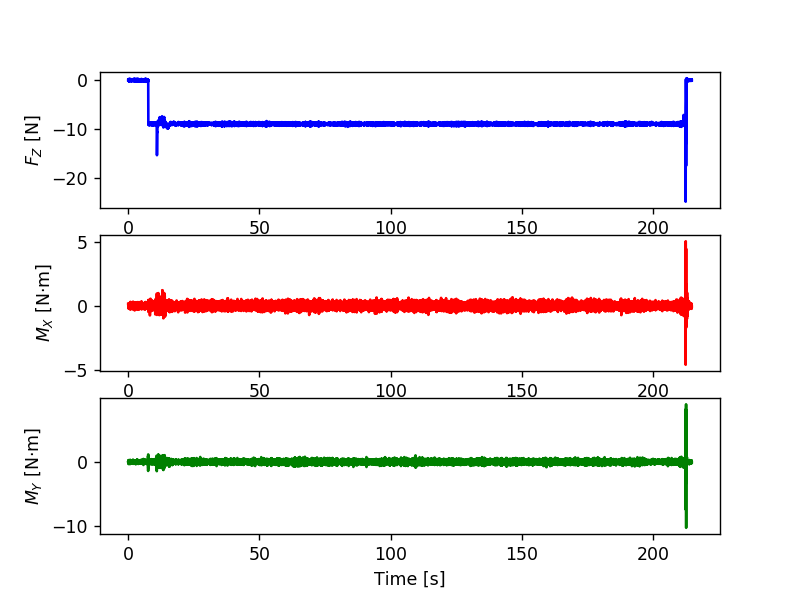

In [31]:
# Generating multipliers for rpms for Z-body force and X, Y body momements
Z_f_coeff = -1.*np.ones(X.shape)

X_m_coeff = np.ones(X.shape) # Initial matrix
X_m_coeff[:, [1, 2]] = -1. # motors 1, 4 positive, 2, 3 are negative
X_m_coeff = X_m_coeff*vehicle.l*np.cos(vehicle.arm_angle_from_xbody)

Y_m_coeff = np.ones(X.shape)
Y_m_coeff[:, [2, 3]] = -1. # motors 1, 4 positive, 2, 3 are negative
Y_m_coeff = Y_m_coeff*vehicle.l*np.sin(vehicle.arm_angle_from_xbody)

# Calculating forces and moments from motor force (In quaternion time scale for now)
F_Z_B = a_unexplained[:, 2]*vehicle.mass
M_X_B = alpha_unexplained[:, 0]*vehicle.Ixx
M_Y_B = alpha_unexplained[:, 1]*vehicle.Iyy

fig, ax = plt.subplots(3,1)

# Plotting
ax[0].plot(t_q, F_Z_B, color='b')
ax[1].plot(t_q, M_X_B, color='r')
ax[2].plot(t_q, M_Y_B, color='g')

ax[0].set_ylabel('$F_Z$ [N]')
ax[1].set_ylabel('$M_X$ [N$\cdot$m]')
ax[2].set_ylabel('$M_Y$ [N$\cdot$m]')
ax[2].set_xlabel('Time [s]')

plt.show()

In [32]:
# setting up output variable y

# Need an Nx1 vector not a N list
F_Z_B = F_Z_B.reshape((t_q.shape[0],1))
M_X_B = M_X_B.reshape((t_q.shape[0],1))
M_Y_B = M_Y_B.reshape((t_q.shape[0],1))

# Interpolating into motor time
t1 = time.time()
F_Z_B_tM = linear_interpolation(t_q, F_Z_B, t_motors)
M_X_B_tM = linear_interpolation(t_q, M_X_B, t_motors)
M_Y_B_tM = linear_interpolation(t_q, M_Y_B, t_motors)
print('Time to interpolate Nx1 vector 3 times: %f' % (time.time() - t1))

# Interpolating into motor time
t1 = time.time()
y = linear_interpolation(t_q, np.concatenate((F_Z_B, M_X_B, M_Y_B), axis=1), t_motors)
"""
F_Z_B_tM = y[:, 0]
M_X_B_tM = y[:, 1]
M_Y_B_tM = y[:, 2]
"""
print('Time to interpolate Nx1 1 time: %f' % (time.time() - t1))

# Concatenating into y vector
#y = np.concatenate((F_Z_B_tM, M_X_B_tM, M_Y_B_tM), axis=0)
y = y.flatten('F') # column style flattining -> [Fz^T, Mx^T, My^t]
y = y.reshape((y.shape[0], 1))
print(y)

Time to interpolate Nx1 vector 3 times: 117.327588
Time to interpolate Nx1 1 time: 36.658989
[[-0.24203845]
 [-0.2097111 ]
 [-8.91551976]
 ...
 [ 1.13258837]
 [ 1.20996874]
 [ 0.52914055]]


In [33]:
# Setting up regression matrix
rpm2 = motor_rpms[['rpm1', 'rpm2', 'rpm3', 'rpm4']].values ** 2
Xreg = np.concatenate((Z_f_coeff*rpm2, X_m_coeff*rpm2, Y_m_coeff*rpm2), axis=0)
print(Xreg)

[[-14992128.76671129  -1065996.76108384  -3065667.13921608
    -997737.12144905]
 [-14992128.76671129  -1065996.76108384  -3065667.13921608
    -997737.12144905]
 [ -3996801.90902354 -15705463.8180142  -21029134.41041207
  -16172042.03739762]
 ...
 [   897979.53707545   1180618.86222853   -702159.87517582
   -1222464.35190795]
 [   897979.53707545   1180618.86222853   -702159.87517582
   -1222464.35190795]
 [   897979.53707545   1180618.86222853   -702159.87517582
   -1222464.35190795]]


In [34]:
# Trying regression
model = LinearRegression(fit_intercept=False).fit(Xreg, y)
print(model.coef_, model.intercept_)
print(np.mean(model.coef_))
print("Cumulative R^2: %f" % model.score(Xreg, y))
print("F_Z R^2: %f" % model.score(Z_f_coeff*rpm2, y[:int(y.shape[0]/3)]))
print("M_X R^2: %f" % model.score(X_m_coeff*rpm2, y[int(y.shape[0]/3):int(2*y.shape[0]/3)]))
print("M_Y R^2: %f" % model.score(Y_m_coeff*rpm2, y[int(2*y.shape[0]/3):]))

[[2.76356882e-08 1.31964034e-08 3.01084918e-08 1.38704181e-08]] 0.0
2.1202750370806402e-08
Cumulative R^2: 0.991718
F_Z R^2: -2.661346
M_X R^2: 0.027129
M_Y R^2: 0.020843


In [35]:
yp = model.predict(Xreg)
yp = yp.reshape((int(yp.shape[0]/3), 3), order='F')
print(yp)

[[-0.53452676  0.02896082  0.02900191]
 [-0.53452676  0.02896082  0.02900191]
 [-1.17517851 -0.04550794 -0.04857826]
 ...
 [-0.87214746  0.00505148  0.00229914]
 [-0.87214746  0.00505148  0.00229914]
 [-0.87214746  0.00505148  0.00229914]]


<IPython.core.display.Javascript object>


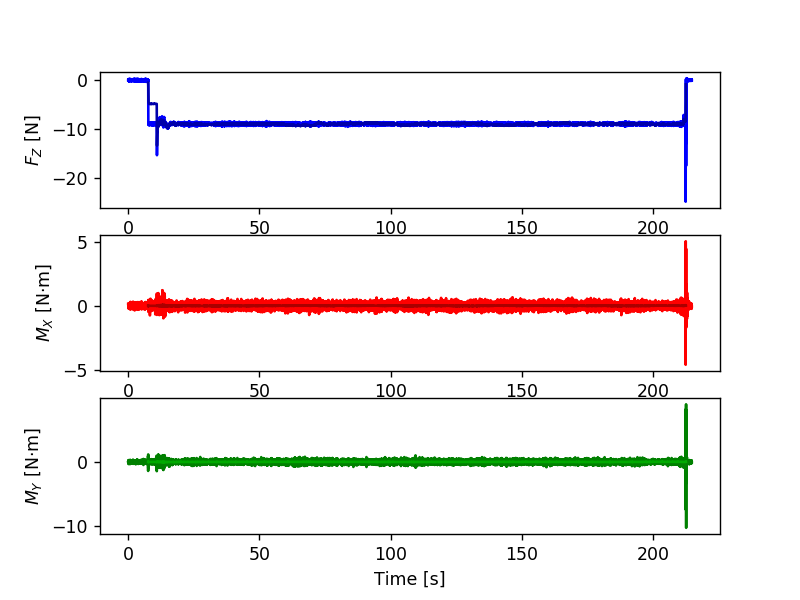

(77287, 3)


In [36]:
fig, ax = plt.subplots(3,1)

d2r = np.pi/180.

# Plotting
ax[0].plot(t_q, F_Z_B, color='b')
"""
ax[1].plot(t_q, omegadot_I_B[:, 0]*vehicle.Ixx, color='r')
ax[2].plot(t_q, omegadot_I_B[:, 1]*vehicle.Iyy, color='g')
"""
ax[1].plot(t_q, M_X_B, color='r')
ax[2].plot(t_q, M_Y_B, color='g')


ax[0].plot(t_motors, yp[:,0], color='#0000aa')
ax[1].plot(t_motors, yp[:,1], color='#aa0000')
ax[2].plot(t_motors, yp[:,2], color='#00aa00')


ax[0].set_ylabel('$F_Z$ [N]')
ax[1].set_ylabel('$M_X$ [N$\cdot$m]')
ax[2].set_ylabel('$M_Y$ [N$\cdot$m]')
ax[2].set_xlabel('Time [s]')

plt.show()